# EXPLORATORY DATA ANALYSIS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
from scipy import stats
import random
import os

In [2]:
img_dir = "/kaggle/input/csiro-biomass/train"
df = pd.read_csv("/kaggle/input/csiro-biomass/train.csv")
print(df.head())

TARGET_cols = ['Dry_Green_g', 'Dry_Dead_g', 'Dry_Clover_g', 'GDM_g', 'Dry_Total_g']

WEIGHTS = {
    'Dry_Green_g': 0.1,
    'Dry_Dead_g': 0.1,
    'Dry_Clover_g': 0.1,
    'GDM_g': 0.2,
    'Dry_Total_g': 0.5
}

                    sample_id              image_path Sampling_Date State  \
0  ID1011485656__Dry_Clover_g  train/ID1011485656.jpg      2015/9/4   Tas   
1    ID1011485656__Dry_Dead_g  train/ID1011485656.jpg      2015/9/4   Tas   
2   ID1011485656__Dry_Green_g  train/ID1011485656.jpg      2015/9/4   Tas   
3   ID1011485656__Dry_Total_g  train/ID1011485656.jpg      2015/9/4   Tas   
4         ID1011485656__GDM_g  train/ID1011485656.jpg      2015/9/4   Tas   

           Species  Pre_GSHH_NDVI  Height_Ave_cm   target_name   target  
0  Ryegrass_Clover           0.62         4.6667  Dry_Clover_g   0.0000  
1  Ryegrass_Clover           0.62         4.6667    Dry_Dead_g  31.9984  
2  Ryegrass_Clover           0.62         4.6667   Dry_Green_g  16.2751  
3  Ryegrass_Clover           0.62         4.6667   Dry_Total_g  48.2735  
4  Ryegrass_Clover           0.62         4.6667         GDM_g  16.2750  


In [3]:
print("="*80)
print("📊 DATA OVERVIEW")
print("="*80)
print(f"\nShape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Memory: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"Number of states: {df['State'].nunique()}")
print(f"Number of species combinations: {df['Species'].nunique()}")

📊 DATA OVERVIEW

Shape: 1,785 rows × 9 columns
Memory: 0.68 MB
Number of states: 4
Number of species combinations: 15


In [4]:
def data_to_data(data_dir:str) -> pd.DataFrame:
    print("Loading Data....")
    df_long = pd.read_csv(data_dir)
    df_long['image_id'] = df_long['sample_id'].str.split('__').str[0]
    print("\n🔄 Converting to wide format...")
    meta_cols = ['image_path', 'Sampling_Date', 'State', 'Species', 
                 'Pre_GSHH_NDVI', 'Height_Ave_cm']
    
    df_wide = df_long.pivot_table(
        index=['image_id'] + meta_cols,
        columns='target_name',
        values='target',
        aggfunc='first'
    ).reset_index()

    print("✅ Preprocessing complete!\n")
    

    return df_wide

df = data_to_data("/kaggle/input/csiro-biomass/train.csv")
df.head()

Loading Data....

🔄 Converting to wide format...
✅ Preprocessing complete!



target_name      image_id              image_path Sampling_Date State  \
0            ID1011485656  train/ID1011485656.jpg      2015/9/4   Tas   
1            ID1012260530  train/ID1012260530.jpg      2015/4/1   NSW   
2            ID1025234388  train/ID1025234388.jpg      2015/9/1    WA   
3            ID1028611175  train/ID1028611175.jpg     2015/5/18   Tas   
4            ID1035947949  train/ID1035947949.jpg     2015/9/11   Tas   

target_name            Species  Pre_GSHH_NDVI  Height_Ave_cm  Dry_Clover_g  \
0              Ryegrass_Clover           0.62         4.6667        0.0000   
1                      Lucerne           0.55        16.0000        0.0000   
2            SubcloverDalkeith           0.38         1.0000        6.0500   
3                     Ryegrass           0.66         5.0000        0.0000   
4                     Ryegrass           0.54         3.5000        0.4343   

target_name  Dry_Dead_g  Dry_Green_g  Dry_Total_g    GDM_g  
0               31.9984      16.2751      48.2735  16.2750  
1                0.0000       7.6000       7.6000   7.6000  
2                0.0000       0.0000       6.0500   6.0500  
3               30.9703      24.2376      55.2079  24.2376  
4               23.2239      10.5261      34.1844  10.9605

In [5]:
def analyze_data_quality(df:pd.DataFrame) -> None:
    print("="*80)
    print("📊 DATA QUALITY ASSESMENT")
    print("="*80)

    print("\n MISSING COUNT")
    print(df.isnull().sum())

    print("\n DATA TYPES CHECK")
    print(df.dtypes.value_counts())

    print("\n DUPLICATES CHECK")
    n_duplicates = df.duplicated(subset='image_id').sum()
    print(f"Duplicate Image Ids:{n_duplicates}")

analyze_data_quality(df)

📊 DATA QUALITY ASSESMENT

 MISSING COUNT
target_name
image_id         0
image_path       0
Sampling_Date    0
State            0
Species          0
Pre_GSHH_NDVI    0
Height_Ave_cm    0
Dry_Clover_g     0
Dry_Dead_g       0
Dry_Green_g      0
Dry_Total_g      0
GDM_g            0
dtype: int64

 DATA TYPES CHECK
float64    7
object     5
Name: count, dtype: int64

 DUPLICATES CHECK
Duplicate Image Ids:0


### Randomly Sample images and display

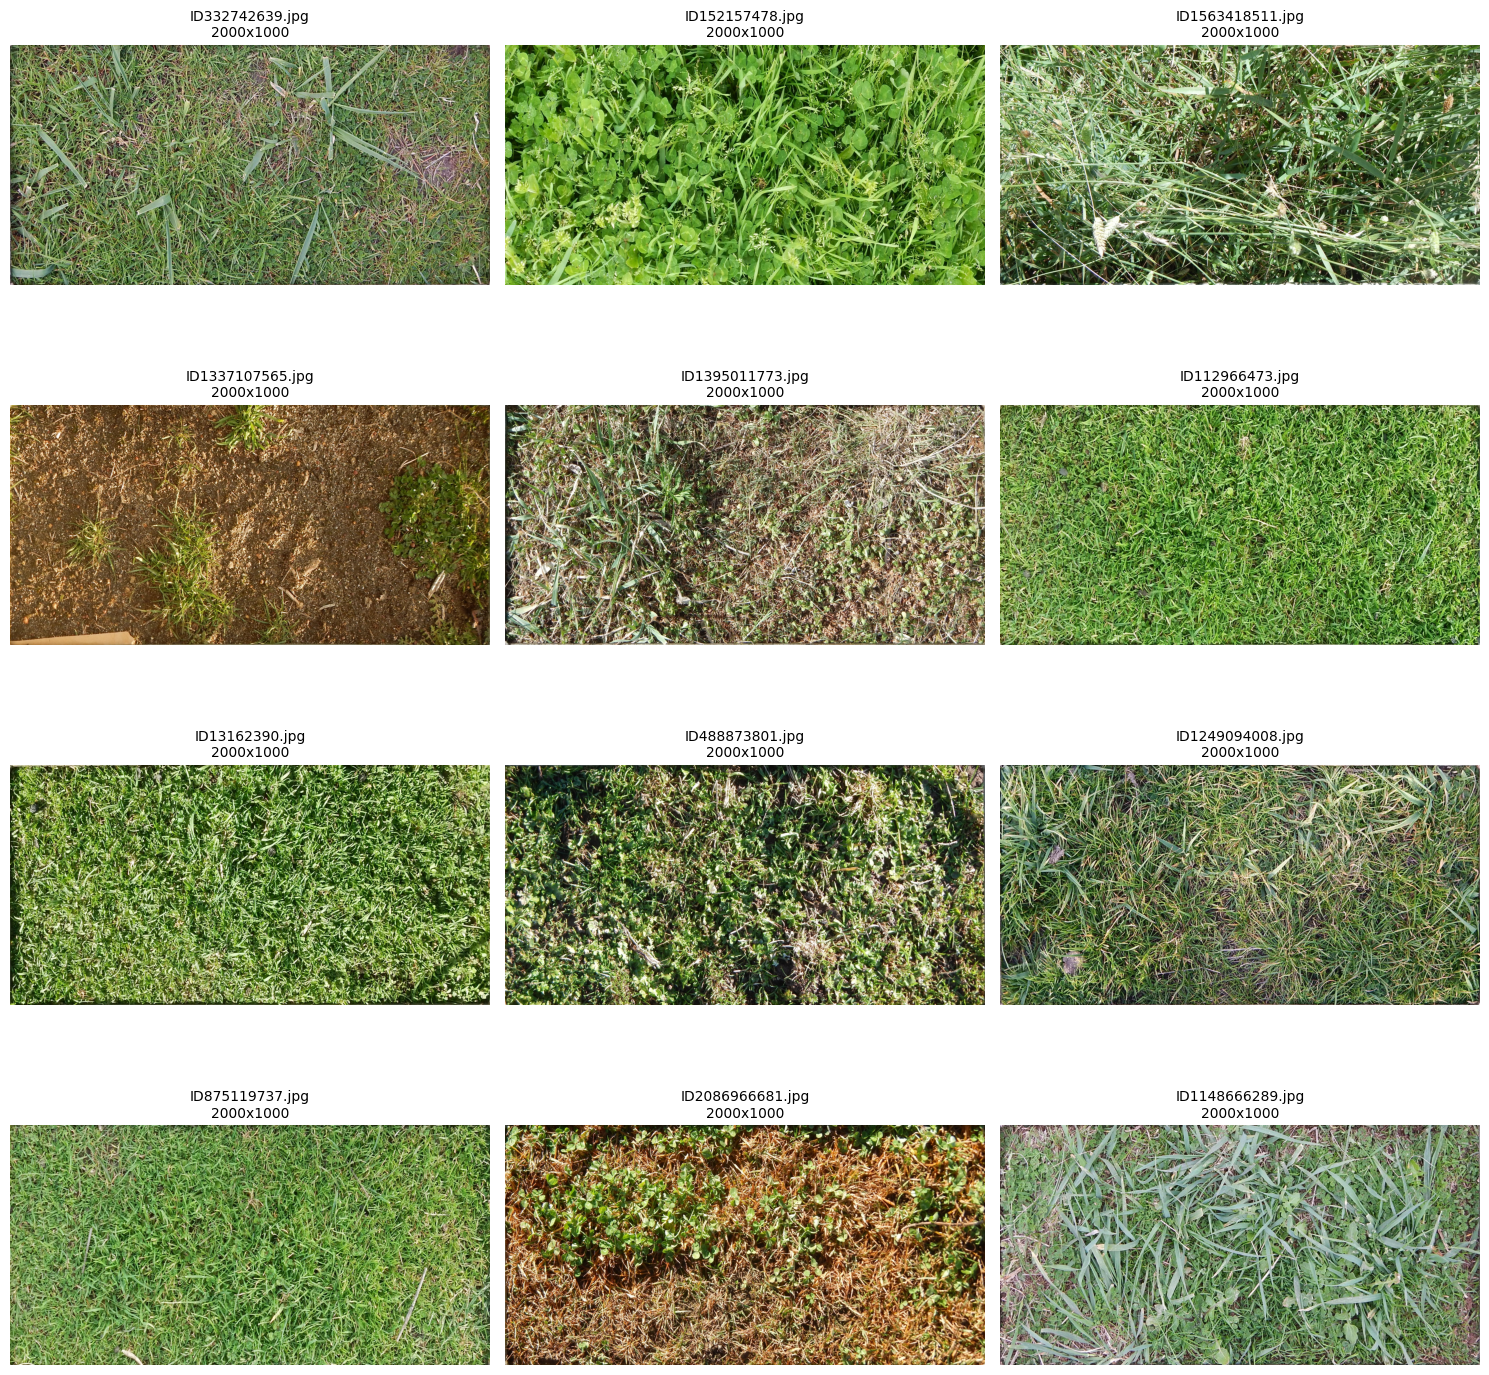

In [6]:
def sample_images(image_dir:Path,n_samples:int,fig_size=(15,15),seed=None) -> list:
    if seed is not None:
        random.seed(seed)

    image_dir = Path(image_dir)
    valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff'}
    image_files = [f for f in image_dir.rglob('*') 
                   if f.suffix.lower() in valid_extensions and f.is_file()]
    
    if len(image_files) == 0:
        print(f"No images found in {image_dir}")
        return []

    n_samples = min(n_samples, len(image_files))
    sampled_files = random.sample(image_files,n_samples)

    n_cols = int(n_samples ** 0.5)
    n_rows = (n_samples + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=fig_size)

    if n_samples == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if n_samples > 1 else [axes]

    for idx, (ax, img_path) in enumerate(zip(axes, sampled_files)):
        try:
            img = Image.open(img_path)
            ax.imshow(img)
            ax.set_title(f"{img_path.name}\n{img.size[0]}x{img.size[1]}", 
                        fontsize=10)
            ax.axis('off')
        except Exception as e:
            ax.text(0.5, 0.5, f"Error loading\n{img_path.name}", 
                   ha='center', va='center')
            ax.axis('off')
    
    
    for idx in range(n_samples, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return sampled_files


sampled = sample_images("/kaggle/input/csiro-biomass/train",n_samples=12,seed=42)

In [7]:
def target_analysis(df:pd.DataFrame,target_cols:list) -> pd.DataFrame:
    print("\n" + "="*80)
    print("📈 TARGET VARIABLE STATISTICS")
    print("="*80)

    stats = df[target_cols].describe().T

    stats['cv'] = stats['std'] / stats['mean'] 
    stats['kurtosis'] = df[target_cols].kurtosis()
    stats['skewness'] = df[target_cols].skew()
    stats['comp_weight'] = [WEIGHTS[col] for col in target_cols]

    return stats.round(3)

target_stats = target_analysis(df,TARGET_cols)
target_stats


📈 TARGET VARIABLE STATISTICS


count    mean     std   min     25%     50%     75%      max  \
target_name                                                                  
Dry_Green_g   357.0  26.625  25.401  0.00   8.800  20.800  35.083  157.984   
Dry_Dead_g    357.0  12.045  12.402  0.00   3.200   7.981  17.638   83.841   
Dry_Clover_g  357.0   6.650  12.118  0.00   0.000   1.424   7.243   71.786   
GDM_g         357.0  33.274  24.936  1.04  16.026  27.108  43.676  157.984   
Dry_Total_g   357.0  45.318  27.984  1.04  25.272  40.300  57.880  185.700   

                 cv  kurtosis  skewness  comp_weight  
target_name                                           
Dry_Green_g   0.954     3.912     1.751          0.1  
Dry_Dead_g    1.030     4.200     1.761          0.1  
Dry_Clover_g  1.822     9.068     2.842          0.1  
GDM_g         0.749     3.049     1.559          0.2  
Dry_Total_g   0.618     3.078     1.429          0.5

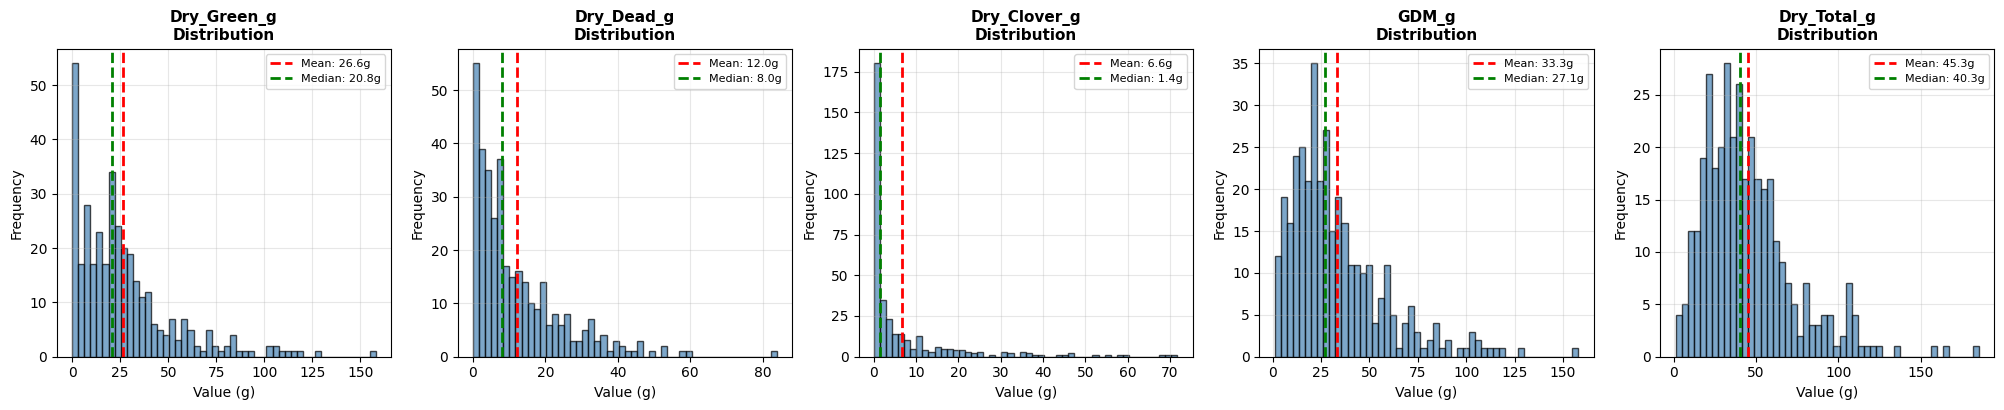

In [8]:
def target_distribution(df:pd.DataFrame,target_cols:list) -> None:
    fig, axes = plt.subplots(1, len(target_cols),
        figsize=(5 * len(target_cols), 4),
        squeeze=False)

    for i, target in enumerate(target_cols):
        data = df[target].dropna()
        axes[0, i].hist(data, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
        axes[0, i].axvline(data.mean(), color='red', linestyle='--', 
                          linewidth=2, label=f'Mean: {data.mean():.1f}g')
        axes[0, i].axvline(data.median(), color='green', linestyle='--', 
                          linewidth=2, label=f'Median: {data.median():.1f}g')
        axes[0, i].set_title(f'{target}\nDistribution', fontsize=11, fontweight='bold')
        axes[0, i].set_xlabel('Value (g)')
        axes[0, i].set_ylabel('Frequency')
        axes[0, i].legend(fontsize=8)
        axes[0, i].grid(True, alpha=0.3)

target_distribution(df,TARGET_cols)

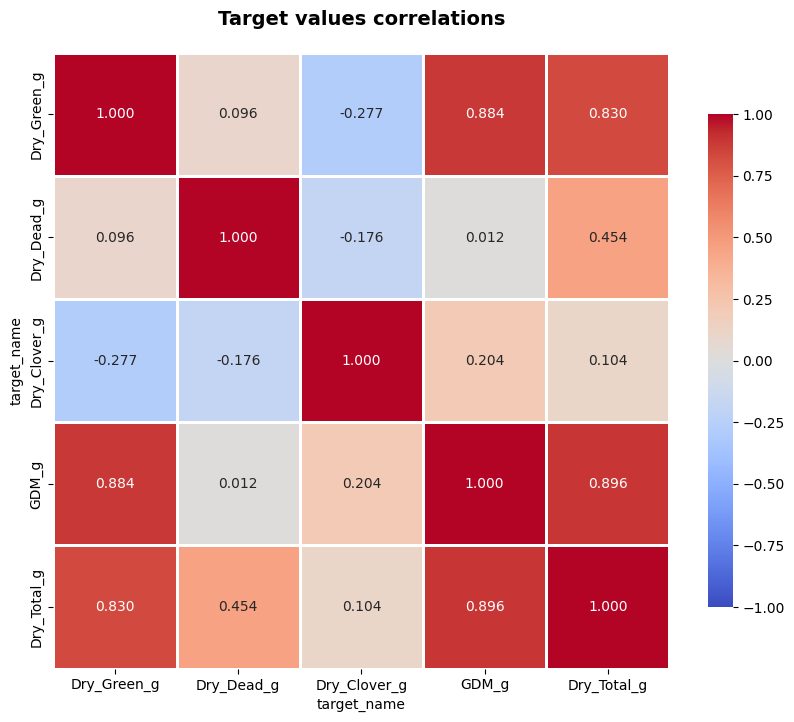

In [9]:
def correlation_analysis(df:pd.DataFrame,target_cols:list) -> None:
    corr = df[target_cols].corr()

    plt.figure(figsize=(10,8))
    sns.heatmap(corr, annot=True, fmt='.3f',cmap='coolwarm',center=0,square=True,linewidths=2,cbar_kws={"shrink": 0.8}, vmin=-1, vmax=1)
    plt.title('Target values correlations',fontsize=14,fontweight='bold',pad=20)
    plt.tight_layout
    plt.show()

correlation_analysis(df,TARGET_cols)


 Outlier Detection: Dry_Green_g

 IQR 
Bounds: [-30.63g, 74.51g]
Outliers: 20 (5.6%)


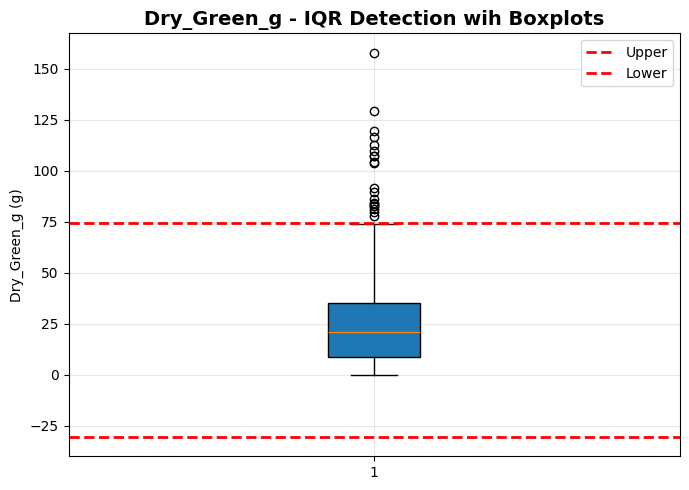


 Outlier Detection: Dry_Dead_g

 IQR 
Bounds: [-18.46g, 39.29g]
Outliers: 14 (3.9%)


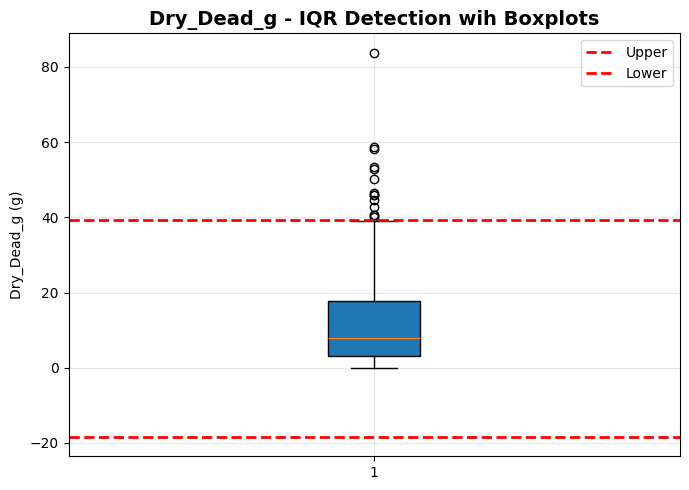


 Outlier Detection: Dry_Clover_g

 IQR 
Bounds: [-10.86g, 18.11g]
Outliers: 41 (11.5%)


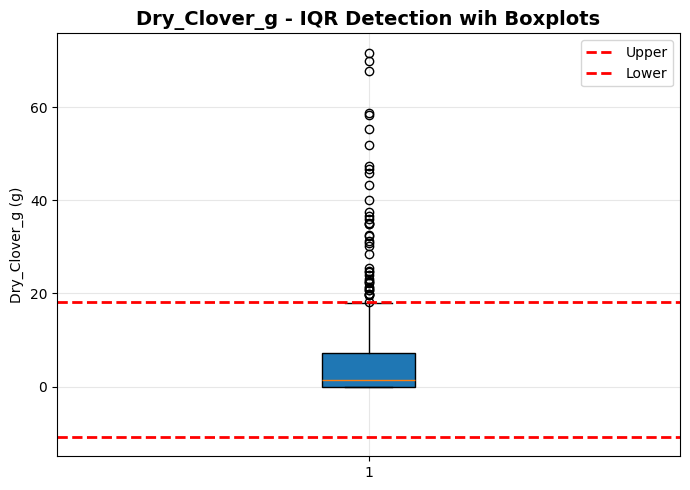


 Outlier Detection: GDM_g

 IQR 
Bounds: [-25.45g, 85.15g]
Outliers: 16 (4.5%)


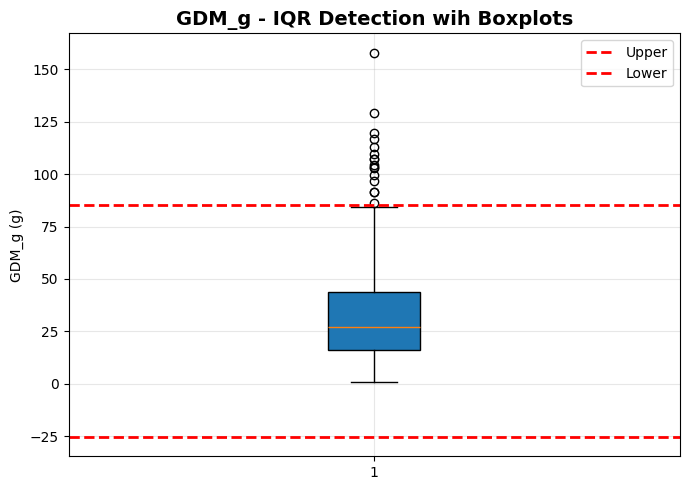


 Outlier Detection: Dry_Total_g

 IQR 
Bounds: [-23.64g, 106.79g]
Outliers: 16 (4.5%)


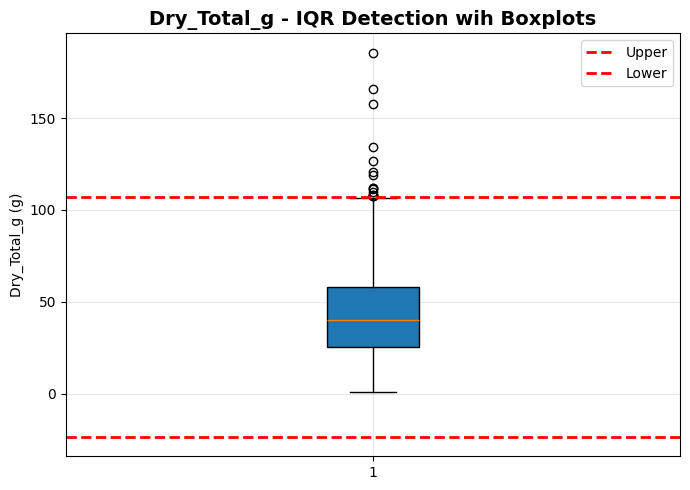

In [10]:
def outlier_detection(df:pd.DataFrame,target:str) -> dict:
    print(f"\n Outlier Detection: {target}")
    print("="*60)

    Q1 = df[target].quantile(0.25)
    Q3 = df[target].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    iqr_outliers = df[(df[target] < lower_bound) | (df[target] > upper_bound)]
    
    print(f"\n IQR ")
    print(f"Bounds: [{lower_bound:.2f}g, {upper_bound:.2f}g]")
    print(f"Outliers: {len(iqr_outliers):,} ({len(iqr_outliers)/len(df)*100:.1f}%)")

    fig, ax = plt.subplots(figsize=(7,5))

    bp = ax.boxplot(df[target],vert=True,patch_artist=True)
    ax.axhline(upper_bound, color='red', linestyle='--', linewidth=2, label='Upper')
    ax.axhline(lower_bound,color='red', linestyle='--', linewidth=2, label='Lower')
    ax.set_title(f'{target} - IQR Detection wih Boxplots',fontsize=14,fontweight='bold')
    ax.set_ylabel(f'{target} (g)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return {
        'iqr_outliers': iqr_outliers
    }


results = {}
for target in TARGET_cols:
    results[target] = outlier_detection(df,target)

### Exploring Target vs Metadata Relationships


 Dry_Total_g shows variation across states and species

 Dry_Green_g shows variation across states and species

 GDM_g shows variation across states and species


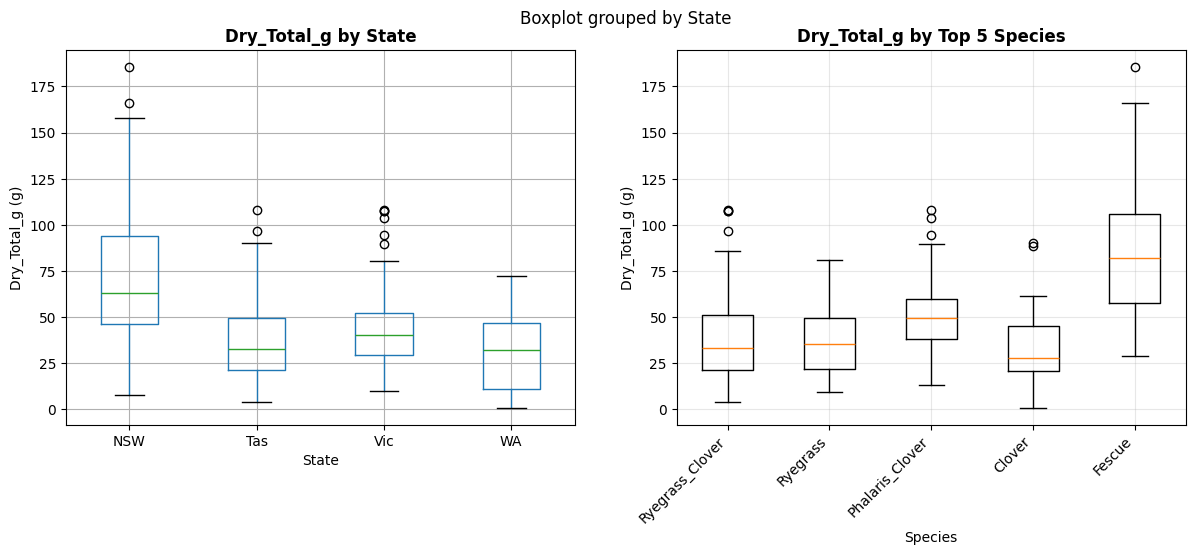

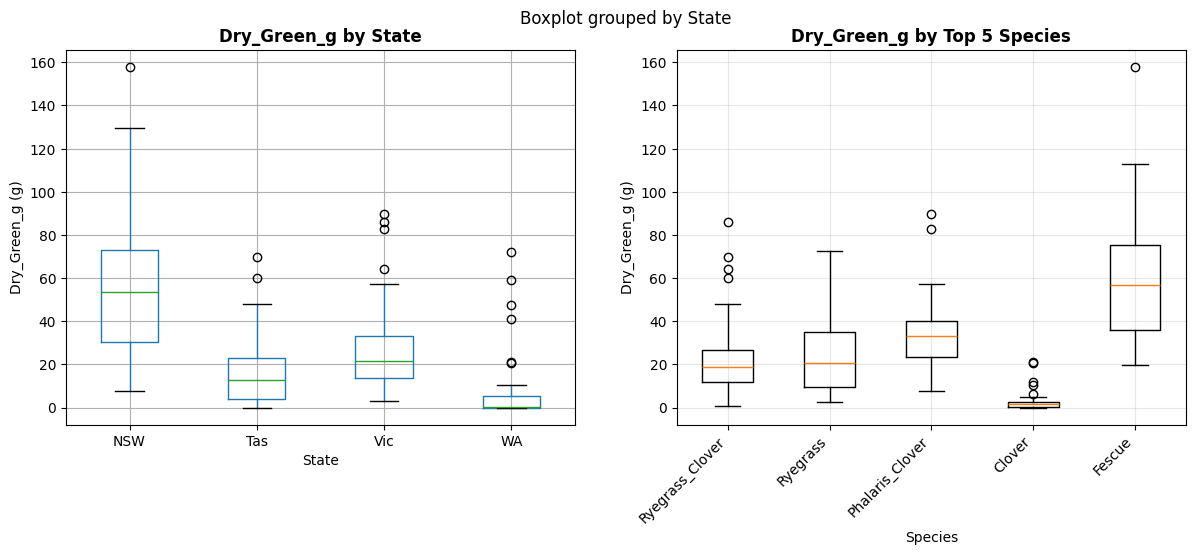

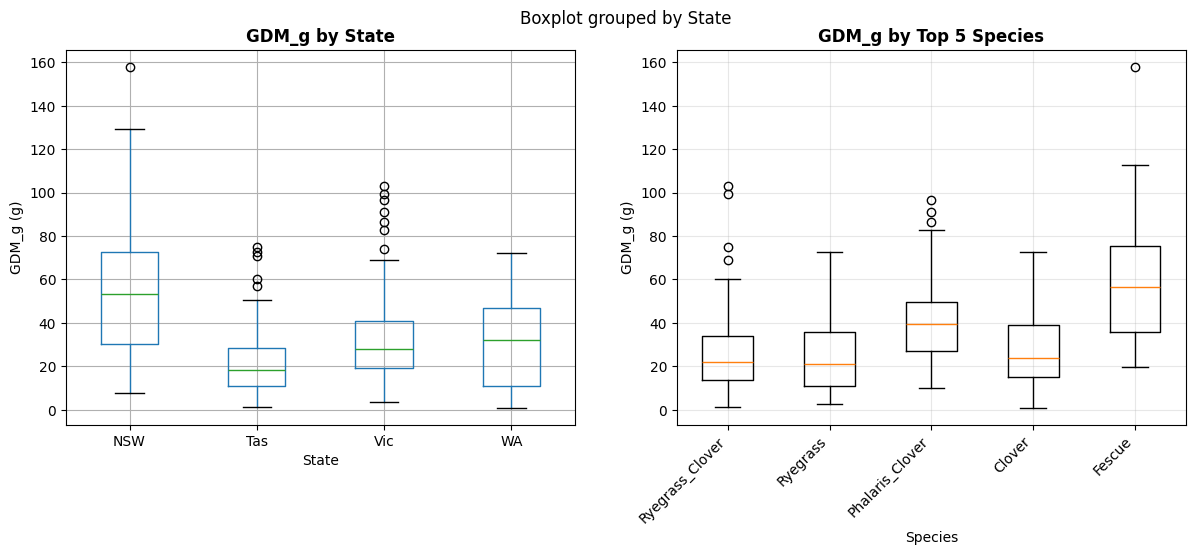

In [11]:
def plot_target_by_metadata(df: pd.DataFrame, target: str = 'Dry_Total_g') -> None:
   
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    axes = axes.flatten()
    
   
    df.boxplot(column=target, by='State', ax=axes[0])
    axes[0].set_title(f'{target} by State', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('State')
    axes[0].set_ylabel(f'{target} (g)')
    plt.sca(axes[0])
    plt.xticks(rotation=0)
    
    
    top_species = df['Species'].value_counts().head(5).index
    df_top = df[df['Species'].isin(top_species)]
    species_data = [df_top[df_top['Species'] == s][target].dropna() for s in top_species]
    bp = axes[1].boxplot(species_data, tick_labels=[s[:20] for s in top_species])
    axes[1].set_title(f'{target} by Top 5 Species', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Species')
    axes[1].set_ylabel(f'{target} (g)')
    plt.sca(axes[1])
    plt.xticks(rotation=45, ha='right')
    axes[1].grid(True, alpha=0.3)
    
    
   


for target in ['Dry_Total_g', 'Dry_Green_g', 'GDM_g']:
    plot_target_by_metadata(df, target)
    print(f"\n {target} shows variation across states and species")

In [12]:
def single_image_detail(df:pd.DataFrame,image_base_dir:str,image_id=str) -> None:

    matching = df[df['image_id'] == image_id]
    if len(matching) == 0:
        print(f"❌ Image ID '{image_id}' not found")
        return
    row = matching.iloc[0]
    img_path = Path(image_base_dir) / row['image_path']
    
    fig = plt.figure(figsize=(16, 6))
    gs = fig.add_gridspec(1, 2, width_ratios=[1.5, 1])
    ax_img = fig.add_subplot(gs[0])
    ax_info = fig.add_subplot(gs[1])

    if img_path.exists():
        img = Image.open(img_path)
        ax_img.imshow(img)
        ax_img.axis('off')
        ax_img.set_title(f"Image ID: {row['image_id']}", fontsize=14, fontweight='bold')
    else:
        ax_img.text(0.5, 0.5, 'Not found', ha='center', va='center', color='red')
        ax_img.axis('off')
    
    
    ax_info.axis('off')
    
    info_text = f"""
IMAGE INFORMATION
{'='*50}

【Metadata】
Date: {row['Sampling_Date']}
State: {row['State']}
Species: {row['Species']}
NDVI: {row['Pre_GSHH_NDVI']:.3f}
Height: {row['Height_Ave_cm']:.2f} cm


【Target Values】
Dry_Total: {row['Dry_Total_g']:.2f} g (100%)
  ├─ Dry_Green: {row['Dry_Green_g']:.2f} g
  ├─ Dry_Dead: {row['Dry_Dead_g']:.2f} g
  └─ Dry_Clover: {row['Dry_Clover_g']:.2f} g 
GDM: {row['GDM_g']:.2f} g
    """
    
    ax_info.text(0.1, 0.5, info_text, fontsize=10, 
                verticalalignment='center', family='monospace',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    plt.tight_layout()
    plt.show()

### Detailed view of the first image

/tmp/ipykernel_17/3408575396.py:51: UserWarning: Glyph 12304 (\N{LEFT BLACK LENTICULAR BRACKET}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_17/3408575396.py:51: UserWarning: Glyph 12305 (\N{RIGHT BLACK LENTICULAR BRACKET}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12304 (\N{LEFT BLACK LENTICULAR BRACKET}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12305 (\N{RIGHT BLACK LENTICULAR BRACKET}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


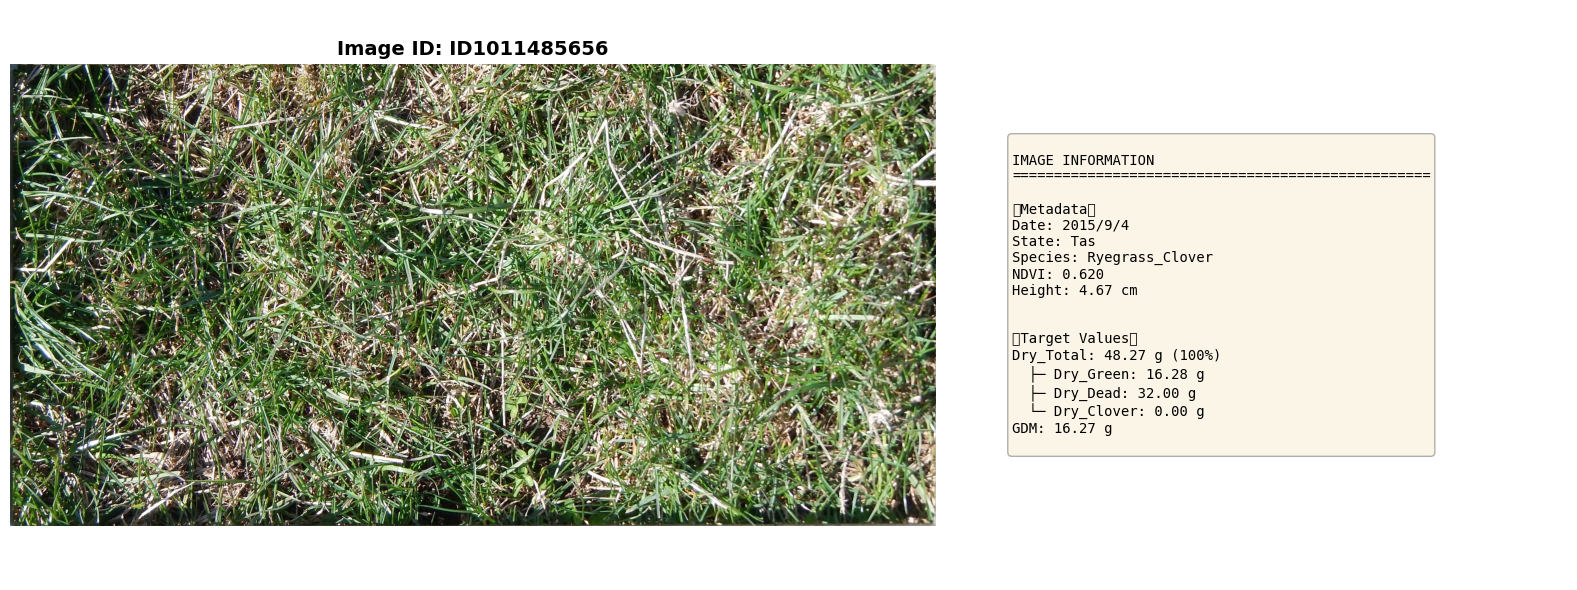

In [13]:
first_image_id = df.iloc[0]['image_id']
single_image_detail(df, "/kaggle/input/csiro-biomass", first_image_id)

## 💡 Key Insights from the above Analaysis

### Data Characteristics:
**Target Distribution**
- All targets are right-skewed.
- outliers present in all targets
- High correlations are present in some targets

### Metadata Patterns:
**Geographic variations**

- Different biomass levels across states
- Seasonal variations exist.

### Modelling Techniques Recommended:
- Targets are all skewed; transformation in the training phase is recommended.
- Cross-validation by stratifying state would be the best validation strategy.
- The model should have a Multi-headed Architecture (one head per target) or predict the highly correlated targets and derive rest mathematically
- Should use a shared backbone better with a gated convolution layer for global and local features.
- Standard Argumentation recommended